In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import random
from sklearn.metrics.pairwise import cosine_similarity
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import psycopg2 as pg2
import psycopg2.extras as pgex
this_host='34.211.59.66'
this_user='postgres'
this_password='postgres'
conn = pg2.connect(host = this_host, 
                        user = this_user,
                        password = this_password)

sql_select = '''select created_at, location, tweet_content, cleaned_tweet, hashtags from tweets where hashtags is not null;'''

cur = conn.cursor(cursor_factory=pgex.RealDictCursor)
cur.execute(sql_select)
rows = cur.fetchall()
conn.close()
df = pd.DataFrame(rows)
df.reset_index(inplace = True)

In [3]:
df['created_datetime'] = pd.to_datetime(df['created_at'])
df['year'] = df.created_datetime.apply(lambda x: x.year)
df['month'] = df.created_datetime.apply(lambda x: x.month)
df['day'] = df.created_datetime.apply(lambda x: x.day)
#df['dayofweek'] = df.created_datetime.apply(lambda x: x.dayofweek)
df['hour'] = df.created_datetime.apply(lambda x: x.hour)

In [4]:
import pickle
!pip install redis
import redis
redis_ip = '34.211.59.66'
r = redis.StrictRedis(redis_ip)
r.keys()

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


[b'hashtag_mean_arr_window4',
 b'hashtag_mean_arr_window21',
 b'hashtag_mean_arr_window7',
 b'hashtag_mean_arr_window1',
 b'hashtags_countvec_fit',
 b'hashtag_mean_arr_window6',
 b'hashtag_mean_arr_window5',
 b'hashtag_mean_arr_window14',
 b'hashtag_mean_arr_window16',
 b'hashtag_mean_arr_window10',
 b'hashtag_mean_arr_window15',
 b'hashtags_tfidf_fit_transform',
 b'tweet_SVD_fit',
 b'hashtag_mean_arr_window12',
 b'hashtag_mean_arr_window9',
 b'hashtag_mean_arr_window8',
 b'hashtags_countvec_fit_transform',
 b'tweet_tfidf_fit_transform',
 b'hashtag_mean_arr_window11',
 b'hashtag_mean_arr_window0',
 b'hashtag_mean_arr_window18',
 b'hashtag_mean_arr_window20',
 b'hashtag_mean_arr_window3',
 b'hashtag_mean_arr_window2',
 b'hashtag_mean_arr_window17',
 b'tweet_tfidf_fit',
 b'hashtag_mean_arr_window22',
 b'hashtag_mean_arr_window19',
 b'hashtag_mean_arr_window23',
 b'hashtag_mean_arr_window13']

In [5]:
len(df)

147075

In [6]:
hastages_series = df['hashtags']

In [7]:
count_vectorizer = CountVectorizer(min_df = 1, stop_words='english')
hashtags_countvec_fit = count_vectorizer.fit(hastages_series)
hashtags_countvec = pickle.dumps(hashtags_countvec_fit)
r.set('hashtags_countvec_fit', hashtags_countvec)

True

In [8]:
hashtags_countvec = pickle.loads(r.get('hashtags_countvec_fit'))

In [9]:
hashtag_name = hashtags_countvec.get_feature_names()
hashtag_name[5000]

'bellydancer'

In [10]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = 6)
time_gap = timedelta(hours = 2)
windows = int(round(time_delta/time_gap,0))
print('start time: ', min(df['created_datetime']),'\n',\
      'end time:  ', max(df['created_datetime']),'\n',\
      'total hours: ',time_window,'\n',\
      'time lag: ', time_lag,'\n',\
      'time gap: ', time_gap,'\n',\
      'time windows: ', windows)

start time:  2017-05-31 23:50:46 
 end time:   2017-06-08 21:20:38 
 total hours:  189 
 time lag:  6:00:00 
 time gap:  2:00:00 
 time windows:  95


In [11]:
mean_hashtag = np.array(arr_list)
mean_hashtag.shape

NameError: name 'arr_list' is not defined

In [74]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = 2)
time_gap = timedelta(hours = 1)
windows = int(round(time_delta/time_gap,0))

def hashtag_trend(hashtag):
    hashtag = hashtag.lower()
    arr = []
    start_time = min(df['created_datetime'])
    for window in range(windows):
        start_time = start_time
        end_time = start_time + time_lag
        subset = df['hashtags'][((df['created_datetime'] < end_time) & (df['created_datetime'] > start_time))]
        h = subset.str.contains(hashtag).mean()
        arr.append(h)
        start_time += time_gap
    arr = np.array(arr)  
    spikes = []
    tr = np.argwhere(nbafinals_grad>.01).reshape(1,-1)[0]
    [spikes.append(i) for i in tr if (i-1) not in tr]
    plt.plot(arr, label='hashtag frequency') 
    grad = np.gradient(arr)
    plt.plot(grad, label='frequency slope')
    for i in spikes:
        plt.axvline(i, color = 'r',linestyle='dashed', label = 'trending start')
    plt.legend()    
    return arr, grad
    

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


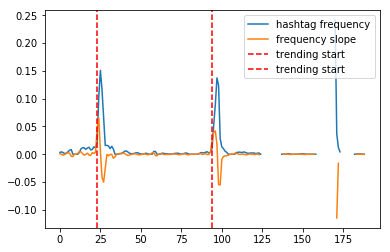

In [75]:
nbafinals, nbafinals_grad = hashtag_trend('nbafinals')

In [38]:
np.argmax(nbafinals_grad).reshape(1,-1)[0]

array([62])

In [58]:
nbafinals_grad[61]

0.0

In [62]:
nbafinals_grad[23]

0.046130180327304676

In [64]:
(np.argwhere(nbafinals_grad>.01).reshape(1,-1)[0])

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([23, 24, 94, 95, 96, 97])

In [67]:
spikes = []
tr = np.argwhere(nbafinals_grad>.01).reshape(1,-1)[0]
[spikes.append(i) for i in tr if (i-1) not in tr]
        
spikes        

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


[23, 94]

In [25]:
np.argmax(nbafinals)

63

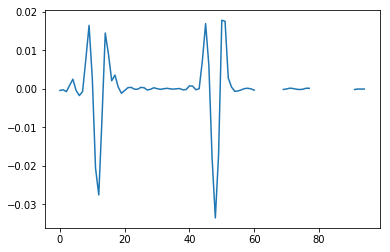

In [26]:
plt.plot(np.gradient(nbafinals_grad))

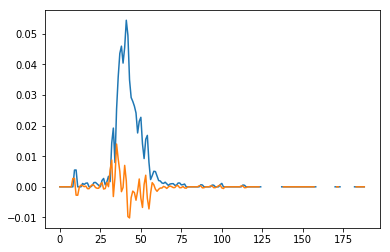

In [44]:
nationaldonutday, nationaldonutdat_grad = hashtag_trend('nationaldonutday')

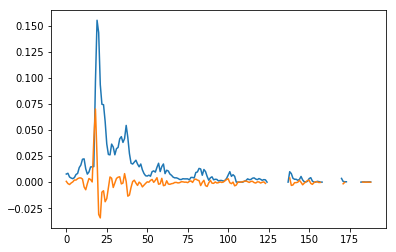

In [46]:
paris, paris_grad = hashtag_trend('paris|climate')

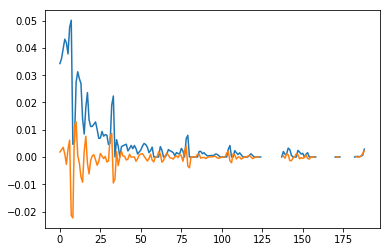

In [47]:
covfefe, covfefe_grad = hashtag_trend('covfefe')

(array([  1.06269926e-03,   8.11359026e-04,   5.99161174e-04,
          0.00000000e+00,   1.40845070e-03,   3.52858151e-03,
          3.74276965e-03,   3.81422481e-03,   3.07324569e-03,
          3.67764631e-03,   7.85142685e-03,   1.25361620e-02,
          1.27845884e-02,   8.88990198e-03,   3.11742293e-03,
          1.93548387e-03,   8.51788756e-04,   9.60153625e-04,
          1.54838710e-03,   1.42374088e-03,   1.24630005e-03,
          7.96939751e-04,   1.02581638e-03,   7.60022801e-04,
          6.28403854e-04,   0.00000000e+00,   0.00000000e+00,
          6.87757909e-04,   1.10253583e-03,   1.30378096e-03,
          3.19081047e-04,   4.04940271e-04,   8.23858955e-04,
          1.45161290e-03,   1.34228188e-03,   9.28160386e-04,
          2.05888408e-04,   5.12689054e-04,   3.52733686e-04,
          6.00961538e-04,   0.00000000e+00,   6.57462196e-04,
          6.71140940e-04,   8.27814570e-04,   1.16201859e-03,
          1.96818107e-03,   9.73859559e-03,   1.81518152e-02,
        

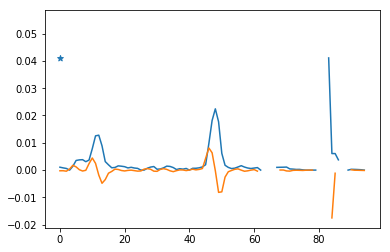

In [19]:
hashtag_trend('Warriors')

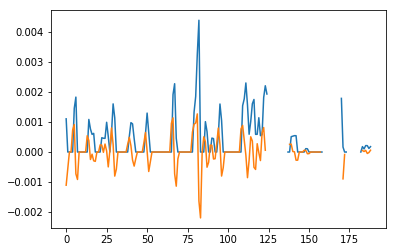

In [48]:
russian, russian_grad = hashtag_trend('Russian')

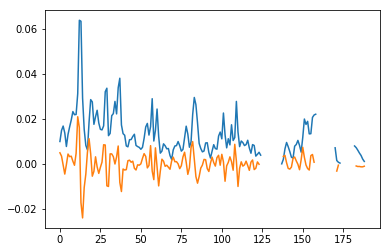

In [49]:
trump, trump_grad = hashtag_trend('trump')

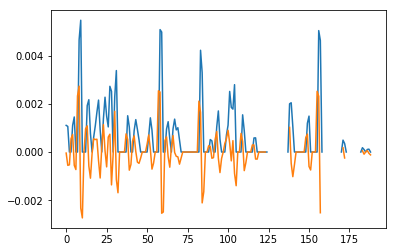

In [50]:
china, china_grad = hashtag_trend('china')